In [1]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
return_depth = False

#dataset_location = "/tmp/clevr-act-6-var-cam2"
dataset_location = "/data/lmbraid19/argusm/datasets/clevr-real-block-simple-v3"
#dataset_location = "/data/lmbraid19/argusm/datasets/clevr-real-block-v3"
#dataset_location = "/data/lmbraid19/argusm/datasets/clevr-real-1of5c-v1"
dataset_location = Path(dataset_location)

model_location = Path("/home/houman/cVLA_test/models")
#model_path = model_location / "clevr-act-7-depth_l40" / "checkpoint-4687"
#model_path = model_location / "clevr-act-6-var-cam2_hf_af_lr3e5" / "checkpoint-4687"
#model_path = model_location / "clevr-act-7-depth_rbg20" / "checkpoint-4687"
model_path = model_location / "clevr-act-7-depth_text_aug" / "checkpoint-4687"
#model_path = model_location / "clevr-act-7-depth_rbg60" / "checkpoint-4687"


#model_path = model_location / "clevr-act-7-depth_depth_l40" / "checkpoint-4687"
if "depth_depth_l40" in str(model_path):
    return_depth = True

print("dataset_location", dataset_location)
if model_path.is_dir():
    print("moadel_path is", model_path)
print(model_path)

dataset_location /data/lmbraid19/argusm/datasets/clevr-real-block-simple-v3
moadel_path is /home/houman/cVLA_test/models/clevr-act-7-depth_text_aug/checkpoint-4687
/home/houman/cVLA_test/models/clevr-act-7-depth_text_aug/checkpoint-4687


In [9]:
# #%pip install ipywidgets
# from huggingface_hub import notebook_login
# notebook_login() 

In [2]:
from tqdm.notebook import tqdm
from math import ceil
from data_loader_images import ImageFolderDataset
from utils_vis import render_example
from utils_trajectory import DummyCamera


test_dataset = ImageFolderDataset("/home/houman/cVLA_test/saved_images")

image_width, image_height = test_dataset[0][0].size
camera_extrinsic = [[[1, 0, 0.0, 0.0], [0, 1, 0, 0], [0, 0, 1, 0]]]
camera_intrinsic = [[[260.78692626953125, 0.0, 322.3820495605469],[ 0.0, 260.78692626953125, 180.76370239257812],[0.0, 0.0, 1.0]]]
camera = DummyCamera(camera_intrinsic, camera_extrinsic, width=image_width, height=image_height)


test_dataset.labels = [dict(prefix="", suffix="")]*len(test_dataset)


/home/houman/miniconda3/envs/cVLA/lib/python3.10/site-packages/sapien/_vulkan_tricks.py:37: UserWarning: Failed to find Vulkan ICD file. This is probably due to an incorrect or partial installation of the NVIDIA driver. SAPIEN will attempt to provide an ICD file anyway but it may not work.
  warn(


In [3]:
from IPython.display import display, HTML
from tqdm.notebook import tqdm
from utils_vis import render_example

def get_image(images):
    if isinstance(images, (list, tuple)):
        return images[-1]
    else:
        return images
    
def get_depth(images):
    if isinstance(images, (list, tuple)):
        return images[0]
    else:
        return None
    
print(len(test_dataset))
num_samples = min(3*1, len(test_dataset))
html_imgs = ""
for i in tqdm(range(num_samples)):
    images, sample = test_dataset[i]
    image = get_depth(images) if return_depth else get_image(images)
    html_img = render_example(image, text=sample["prefix"], label=sample["suffix"], camera=camera)
    
display(HTML(html_imgs))


48


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:

import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.bfloat16
print('Using device:', DEVICE)


MODEL_ID ="google/paligemma2-3b-pt-224"
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)
print("loaded processor.")
model = PaliGemmaForConditionalGeneration.from_pretrained(model_path, torch_dtype=TORCH_DTYPE, device_map="auto")

def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = ["<image>" + label["prefix"] for label in labels]
    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        padding="longest"
    )
    return inputs

Using device: cuda
loaded processor.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


<loc0494><loc0559><loc0059><seg057><seg033><seg016><loc0090><loc0539><loc0076><seg057><seg033><seg016>
tensor([[[ 0.0618, -0.0157,  0.5900],
         [ 0.0432, -0.4345,  0.7600]]])


# Own Data Experiments

  0%|          | 0/3 [00:00<?, ?it/s]


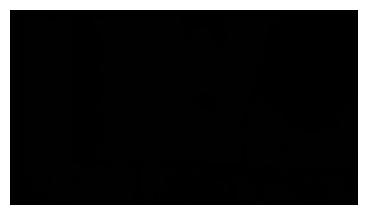
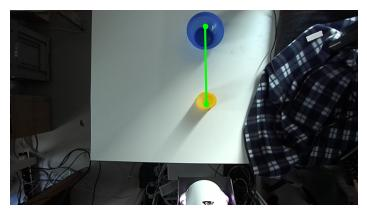
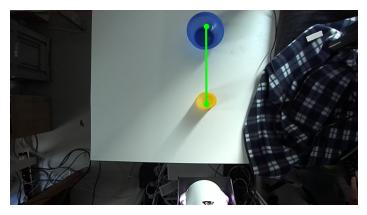

In [8]:
def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = ["<image>" + label["prefix"] for label in labels]
    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        padding="longest"
    ).to(DEVICE)
    return inputs

from tqdm.notebook import tqdm
from math import ceil
from data_loader_images import ImageFolderDataset
from utils_vis import render_example
from utils_trajectory import DummyCamera

robot_state = "<loc0137><loc0794><loc0057><seg058><seg034><seg017>"
x = "yellow cup"
y = "blue bowl"
action_text = "put the {} inside the {}".format(x, y)
prefix = action_text + " " + robot_state
test_dataset.labels = [dict(prefix=prefix, suffix="")]*len(test_dataset)

eval_batch_size = 1
test_samples = 3#len(test_dataset2)
pred_list = []
html_imgs = ""
for start_idx in tqdm(range(0, test_samples, eval_batch_size), total=ceil(test_samples / eval_batch_size)):
    batch = [test_dataset[i] for i in range(start_idx, min(start_idx + eval_batch_size, test_samples))]
    #for e in batch:
    #    augment_sample(e)
    inputs = collate_fn(batch)
    prefix_length = inputs["input_ids"].shape[-1]    

    with torch.inference_mode():
        generation = model.generate(**inputs, max_new_tokens=12, do_sample=False, use_cache=False)
        decoded = [processor.decode(x, skip_special_tokens=True) for x in generation[:, prefix_length:]]
    pred_list.extend(decoded)
    
    for batch_entry, decoded_str in zip(batch, decoded):
        if return_depth:
            (depth, image), sample = batch_entry
        else:
            image, sample = batch_entry
        html_img = render_example(image, text=sample["prefix"], label=sample["suffix"], prediction=decoded_str, camera=camera)
        html_imgs += html_img

plot_images = True
if plot_images:
    from IPython.display import display, HTML
    display(HTML(html_imgs))

In [6]:
test_dataset = ImageFolderDataset("/home/houman/cVLA_test/saved_images")

image_width, image_height = test_dataset[0][0].size
camera_extrinsic = [[[1, 0, 0.0, 0.0], [0, 1, 0, 0], [0, 0, 1, 0]]]
camera_intrinsic = [[[260.78692626953125, 0.0, 322.3820495605469],[ 0.0, 260.78692626953125, 180.76370239257812],[0.0, 0.0, 1.0]]]
camera = DummyCamera(camera_intrinsic, camera_extrinsic, width=image_width, height=image_height)


from mani_skill.examples.utils_traj_tokens import getActionEncDecFunction, unproject_points, decode_caption_xyzrotvec2

print(decoded_str)
print(camera)
token_str = decoded_str
default_action_encoder = "xyzrotvec-cam-proj2"
enc_func, dec_func = getActionEncDecFunction(default_action_encoder)
curve_3d_est, orns_3d_est = dec_func(token_str, camera, robot_pose=None)
print(curve_3d_est)


print(image_width, image_height)
import numpy as np
point_new = np.array((((355, 170, 0.4424514),(355, 50, .518)),))
print(point_new.shape)
point_new_t = torch.tensor(point_new, dtype=torch.float)
print(unproject_points(camera, point_new_t)) # see utils_trajectory.py if this is wrong. I hope not.


                 



<loc0491><loc0578><loc0058><seg057><seg036><seg016><loc0082><loc0577><loc0073><seg057><seg036><seg016>
tensor([[[ 0.0872, -0.0177,  0.5800],
         [ 0.1080, -0.4252,  0.7300]]])
640 360
(1, 2, 3)
tensor([[[ 0.0553, -0.0183,  0.4425],
         [ 0.0648, -0.2597,  0.5180]]])


In [43]:
from mani_skill.examples.utils_traj_tokens import  decode_caption_xyzrotvec2
cam_pos, world_pos = decode_caption_xyzrotvec2(decoded_str, camera)
print(cam_pos)

tensor([[348.4653, 173.8416,   0.5900],
        [361.6031,  28.8563,   0.7600]])


In [15]:
# from matplotlib import pyplot as plt
# import re
# import numpy as np
# results = []
# suffix_nums = []
# predi_nums = []
# for i in range(test_samples):
#     suffix = test_dataset[i][1]["suffix"]
#     prefix = test_dataset[i][1]["prefix"]
#     decoded = decode_dataset[i]
#     suffix_p = [int(x) for x in re.findall(r"<(?:loc|seg)(\d+)>", suffix)]
#     try:#%pip install ipywidgets
# from huggingface_hub import notebook_login
# notebook_login() 
#         decode_p = [int(x) for x in re.findall(r"<(?:loc|seg)(\d+)>", decoded)]
#     except ValueError:
#         continue
#     if len(decode_p) != 12:
#         continue
#     pred_diff = np.array(suffix_p) - np.array(decode_p)
#     results.append(pred_diff)
#     suffix_nums.append(suffix_p)
#     predi_nums.append(decode_p)

# results = np.array(results)
# #suffix_nums = np.array(suffix_nums) / 1024 * 448
# #predi_nums = np.array(predi_nums) / 1024 * 448

# print(results)
# print(np.abs(results).mean(axis=0).round())

# plot_histogram = True
# if plot_histogram:
#     fig, axes = plt.subplots(4, 3, figsize=(10, 12))  # 3 rows x 4 columns of histograms
#     axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
#     for i in range(12):
#         axes[i].hist(results[:, i], bins=20, alpha=0.7, color='blue', edgecolor='black')
#         axes[i].set_title(f'Histogram for Column {i + 1}')
#         axes[i].set_xlabel('Value')
#         axes[i].set_ylabel('Frequency')

#     plt.tight_layout()  # Adjust layout for better spacing
#     plt.show()